# Анализ бизнес-показателей развлекательного приложения

Развлекательное приложение последние несколько месяцев терпит убытки, несмотря на огромные вложения в рекламу.

**Цель проекта:**

   - найти причины, по которым компания терпит убытки

В работе имеются данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
 - лог сервера с данными о посещениях
 - выгрузка покупок
 - о рекламных расходах

Описание файлов

**visits:**
 - идентификатор пользователя
 - страна пользователя
 - тип устройства
 - идентификатор источника перехода
 - дата и время начала сессии
 - дата и время окончания сессии 

**orders:**
 - идентификатор пользователя,
 - дата и время покупки,
 - сумма заказа

**costs**:
    
 - идентификатор рекламного источника
 - дата проведения рекламной кампании
 - расходы на эту кампанию

План выполнения

1. [Общая информация](#start)
2. [Исследовательский анализ данных](#eda)
3. [Рассчет метрик и построение графиков](#metrics)
4. [Функции для расчёта и визуализации](#functions)
5. [Окупаемость рекламы](#roi)
6. [Вывод](#end)

## Изучение общей информации
<a id="start"></a>

Импортируем библиотеки pandas, numpy, datetime, timedelta, matplotlib, seaborn

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

Открываем файлы, изучим общую информацию

In [2]:
visits = pd.read_csv('/datasets/.csv')
orders = pd.read_csv('/datasets/.csv')
costs = pd.read_csv('/datasets/.csv')

In [3]:
display(visits.head())
visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
display(orders.head())
orders.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [5]:
display(costs.head())
costs.info()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


В файлах есть столбцы с типом данных 'object'. Заменим тип на 'category' для уменьшения памяти. Особенно это  полезно для файла 'visits'

In [6]:
visits['Region'] = visits['Region'].astype('category')
visits['Device'] = visits['Device'].astype('category')
visits['Channel'] = visits['Channel'].astype('category')
costs['Channel'] = costs['Channel'].astype('category')

Практически во всех столбцах в файлах присутствуют заглавные буквы. Заменим их на прописные. Также отсутствуют подчеривания. Добавим их.

In [7]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

In [8]:
visits.columns = visits.columns.str.replace(' ', '_')
orders.columns = orders.columns.str.replace(' ', '_')

У столбцов 'session_start', 'session_end'  файла visits, столбца 'event_dt' файла orders и столбца 'dt' файла costs тип данных object. Заменим его на тип datetime.

In [9]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format = '%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'], format = '%d.%m.%Y %H:%M')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

Мы ознаколимлись с данными, столбцы 'session_start', 'session_end'  файла visits, столбца 'event_dt' файла orders и столбца 'dt' файла costs были приведены к типу datetime, столбцы 'region', 'device', 'channel' файла visits и столбец 'channel' файла costs были приведены к типу category.

## Исследовательский анализ данных
<a id="eda"></a>

### Профили пользователей. Минимальная и максимальная даты привлечения пользователей.

Построим профили пользователей с помощью функции 'get_profiles'

In [10]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [11]:
profiles = get_profiles(visits, orders, costs)

In [12]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Найдем минимальную дату привлечения пользователей

In [13]:
profiles['month'].min()

Timestamp('2019-05-01 00:00:00')

Найдем максимальную дату привлечения пользователей

In [14]:
profiles['month'].max()

Timestamp('2019-10-01 00:00:00')

 Пользователи были привлечены в период с 01.05.2019 по 10.01.2019. Мы имеем данные за 5 месяцев.

### Страны, из которых приходят посетители. Найдем какие страны дают больше всего платящих пользователей.

In [15]:
region = profiles.groupby('region').agg({'user_id':'nunique', 'payer': ['sum', 'mean']})
region.columns = region.columns.get_level_values(1)

In [16]:
region.sort_values(by='mean', ascending = False)

,nunique,sum,mean
region,,,
United States,100002,6902,0.069019
Germany,14981,616,0.041119
UK,17575,700,0.039829
France,17450,663,0.037994


### Устройства, которыми пользуются посетители. Найдем с каких устройств чаще всего заходят платящие пользователи.

In [17]:
device = profiles.groupby('device').agg({'user_id':'nunique', 'payer': ['sum', 'mean']})
device.columns = device.columns.get_level_values(1)

In [18]:
device.sort_values(by='mean', ascending = False)

,nunique,sum,mean
device,,,
Mac,30042,1912,0.063644
iPhone,54479,3382,0.062079
Android,35032,2050,0.058518
PC,30455,1537,0.050468


### Рекламные каналы, по которым  шло привлечение пользователей. Найдем какие каналы приносят больше всего платящих пользователей.

In [19]:
channel = profiles.groupby('channel').agg({'user_id':'nunique', 'payer': ['sum', 'mean']})
channel.columns = channel.columns.get_level_values(1)

In [20]:
channel.sort_values(by='mean', ascending = False)

,nunique,sum,mean
channel,,,
FaceBoom,29144,3557,0.122049
AdNonSense,3880,440,0.113402
lambdaMediaAds,2149,225,0.104700
TipTop,19561,1878,0.096007
RocketSuperAds,4448,352,0.079137
WahooNetBanner,8553,453,0.052964
YRabbit,4312,165,0.038265
MediaTornado,4364,156,0.035747
LeapBob,8553,262,0.030633


В этом шаге были построены профили пользователей. Были найдены даты привлечения пользователей:
 - 2019-05-01 - минимальная дата привлечения пользователей
 - 2019-10-01 - максимальная дата привлечения пользователей
 
Также были найдены:
 - США - страна, которая дает больше всего платящих пользователей
 - Mac - устройство, с которого чаще всего заходят платящие пользователи
 - FaceBoom - канал, который приносит больше всего платящих пользователей

## Рассчет метрик и построение графиков
<a id="metrics"></a>

### Продукт:

In [21]:
# выделяем год, номер месяца и номер недели из времени начала сессии

visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date

<ipython-input-21-a775ff62992b>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  visits['session_week'] = visits['session_start'].dt.week


#### Найдем среднее количество уникальных пользователей в день

In [22]:
dau = visits.groupby('session_date').agg({'user_id': 'nunique'})
dau.mean()

user_id    1684.23913
dtype: float64

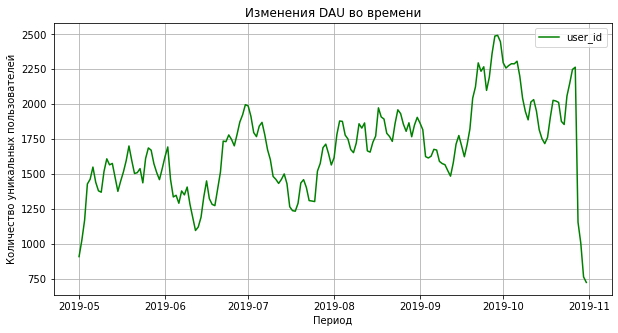

In [23]:
dau.plot(color = 'green', figsize=(10, 5))
plt.xlabel('Период')
plt.ylabel('Количество уникальных пользователей')
plt.title('Изменения DAU во времени')
plt.grid()
plt.show()

Мы видим, что количество уникальных пользователей в день выше в конце рассматриваемого периода, начиная с середины сентября можно отметить рост, за исключением непродолжительного отрезка в сентябре. 

#### Найдем среднее количество уникальных пользователей в неделю

In [24]:
wau = visits.groupby(['session_year', 'session_week']).agg({'user_id': 'nunique'})
wau.mean()

user_id    8353.777778
dtype: float64

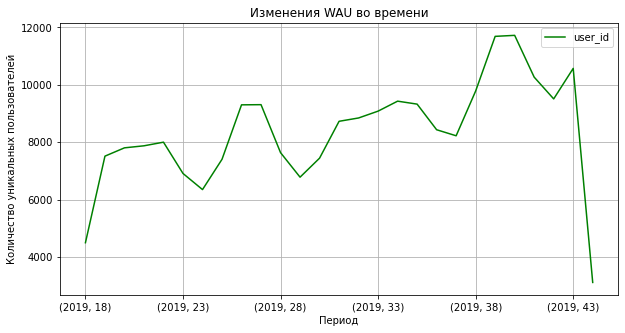

In [25]:
wau.plot(color = 'green', figsize=(10, 5))
plt.xlabel('Период')
plt.ylabel('Количество уникальных пользователей')
plt.title('Изменения WAU во времени')
plt.grid()
plt.show()

Рассматривая изменения WAU во времени тоже можно отметить, что выше всего этот показатель в конце рассматриваемого периода  с 38 по 43 неделю (с 20.09 по 25.10)

#### Найдем среднее количество уникальных пользователей в месяц

In [26]:
mau = visits.groupby(['session_year', 'session_month']).agg({'user_id': 'nunique'})
mau.mean()

user_id    28989.166667
dtype: float64

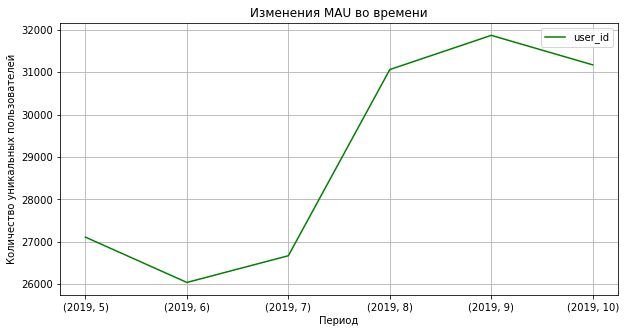

In [27]:
mau.plot(color = 'green', figsize=(10, 5))
plt.xlabel('Период')
plt.ylabel('Количество уникальных пользователей')
plt.title('Изменения MAU во времени')
plt.grid()
plt.show()

Рассматривая изменения MAU во времени, можно отметить большой рост с июля.

#### Найдем среднее количество сессий в день

In [28]:
session_day = visits.groupby('session_date').agg({'user_id': ['count','nunique']})
session_day.columns = ['n_sessions', 'n_users']
session_day['sessions_per_user'] = session_day['n_sessions'] / session_day['n_users']
session_day.head()

,n_sessions,n_users,sessions_per_user
session_date,,,
2019-05-01,909,909,1.0
2019-05-02,1026,1026,1.0
2019-05-03,1170,1170,1.0
2019-05-04,1429,1429,1.0
2019-05-05,1463,1463,1.0


In [29]:
session_day['sessions_per_user'].mean()

1.0000025892246824

Построим гистограмму, отражающую распределение общего числа сессий в день

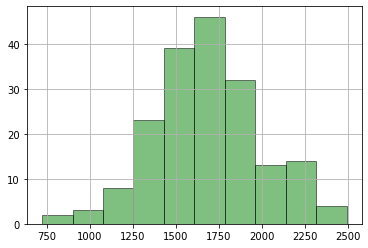

In [30]:
session_day['n_sessions'].hist(alpha=0.5, ec='black', color='green');

In [31]:
session_day['n_sessions'].mean()

1684.2445652173913

Среднее количество сессий в день равно 1 на одного уникального пользователя. Среднее от общего числа сессий в день равно 1684. Рассматривая распределение общего количества сессий в день, видим что максимальное количество сессий находится в диапазоне от 1600 до 1800.

#### Найдем сколько длится одна сессия

In [32]:
sessions = (visits['session_end'] - visits['session_start']).dt.seconds

Построим гистограмму, отражающую распределение длительности сессий.

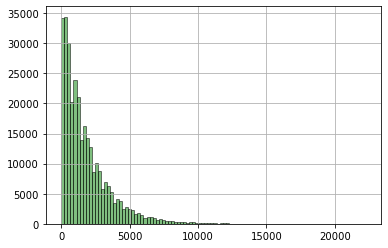

In [33]:
sessions.hist(alpha=0.5, ec='black', color='green', bins=100);

Построим таблицу с параметрами распределения

In [34]:
sessions.describe()

count    309901.000000
mean       1800.084801
std        1803.189827
min           0.000000
25%         540.000000
50%        1260.000000
75%        2520.000000
max       22260.000000
dtype: float64

Рассмотрев гистограмму, видим, что максимальное количество значений расположено в диапазоне близком к нулю. Вероятно присутствовали технические ошибки. Медианное значение равно 1260 сек(21 мин), при сравнении с другими показателями - это хорошее значение.

### Продажи:

#### Найдем сколько времени в среднем проходит с момента первого посещения до покупки.

Найдем данные о первой покупке. Поместим их в переменную 'purchases'

In [35]:
purchases = orders.groupby('user_id').agg({'event_dt': 'first'})

In [36]:
purchases.head()

,event_dt
user_id,
599326,2019-05-07 20:59:09
46006712,2019-06-30 03:46:52
374052872,2019-08-16 07:44:47
414791703,2019-05-04 18:06:41
785077127,2019-06-30 18:35:15


Объеденим 'profiles' и 'purchases', чтобы в одном датасете быди данные о первом посещении и первой покупке.

In [37]:
purchases = purchases.merge(profiles[['user_id', 'first_ts']], on = 'user_id')

Найдем время от момента посещения до момента покупки

In [38]:
purchases['first_purchase'] = (purchases['event_dt'] - purchases['first_ts']).dt.total_seconds() // 60

Найдем медианное значение 'first_pur'

In [39]:
purchases['first_purchase'].median()

1.0

В среднем пользователю требуется 1 минута для перехода к покупке.

#### Найдем среднее число покупок на одного покупателя за день, неделю и месяц

In [40]:
#за день

purchase_day = orders.copy()
purchase_day['dt'] = purchase_day['event_dt'].dt.date
purchase_day = purchase_day.groupby('dt').agg({'user_id': 'nunique', 'event_dt': 'count'})
purchase_day.columns = ['buyer', 'count']
purchase_day['buyer_day'] = purchase_day['count'] / purchase_day['buyer']
purchase_day.head()

,buyer,count,buyer_day
dt,,,
2019-05-01,25,25,1.0
2019-05-02,29,29,1.0
2019-05-03,44,44,1.0
2019-05-04,56,56,1.0
2019-05-05,58,58,1.0


In [41]:
purchase_day['buyer_day'].mean()

1.0000345022303812

In [42]:
# за неделю

purchase_week = orders.copy()
purchase_week['week'] = purchase_week['event_dt'].astype('datetime64[W]')
purchase_week = purchase_week.groupby('week').agg({'user_id': 'nunique', 'event_dt': 'count'})
purchase_week.columns = ['buyer', 'count']
purchase_week['buyer_week'] = purchase_week['count'] / purchase_week['buyer']
purchase_week.head()

,buyer,count,buyer_week
week,,,
2019-04-25,25,25,1.000000
2019-05-02,268,404,1.507463
2019-05-09,395,620,1.569620
2019-05-16,523,767,1.466539
2019-05-23,617,875,1.418152


In [43]:
purchase_week['buyer_week'].mean()

1.3161715525537907

In [44]:
# за месяц

purchase_month = orders.copy()
purchase_month['month'] = purchase_month['event_dt'].astype('datetime64[M]')
purchase_month = purchase_month.groupby('month').agg({'user_id': 'nunique', 'event_dt': 'count'})
purchase_month.columns = ['buyer', 'count']
purchase_month['buyer_month'] = purchase_month['count'] / purchase_month['buyer']
purchase_month.head()

,buyer,count,buyer_month
month,,,
2019-05-01,1226,2962,2.415987
2019-06-01,2130,4875,2.288732
2019-07-01,2801,6556,2.340593
2019-08-01,3476,7582,2.181243
2019-09-01,4124,8430,2.044132


In [45]:
purchase_month['buyer_month'].mean()

2.228447784645054

Построим графики изменения этих метрик во времени

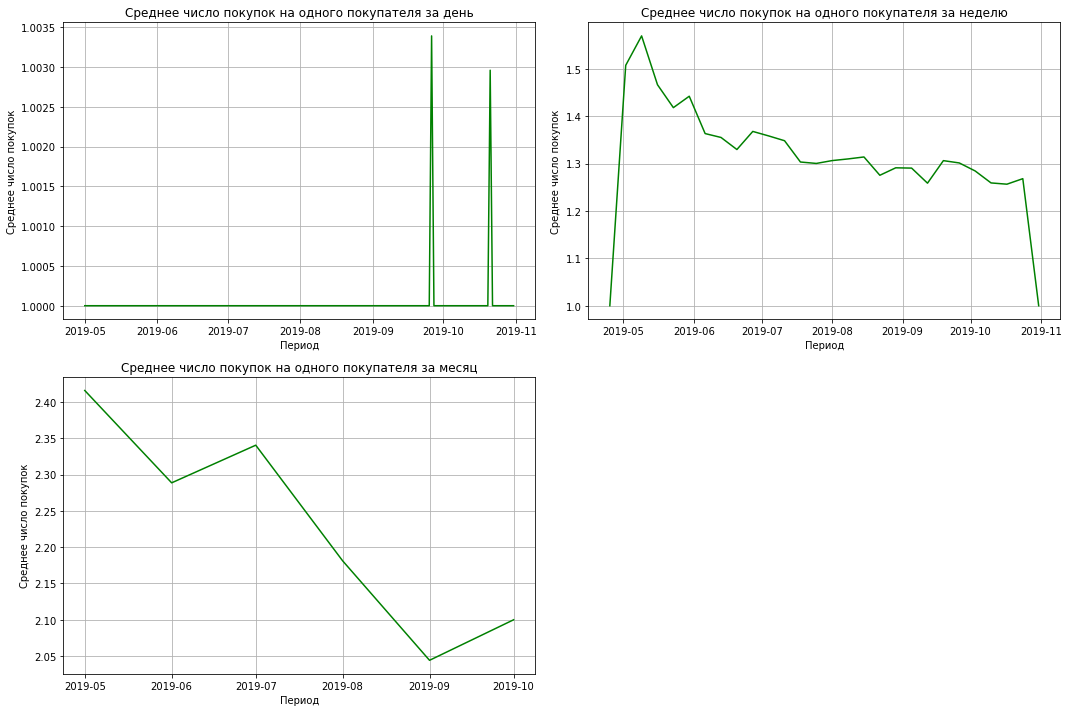

In [46]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)


ax1.plot(purchase_day['buyer_day'], color = 'green')
ax1.set_ylabel('Cреднее число покупок')
ax1.set_xlabel('Период')
ax1.set_title('Cреднее число покупок на одного покупателя за день')
ax1.grid()

ax2.plot(purchase_week['buyer_week'], color='green')
ax2.set_ylabel('Cреднее число покупок')
ax2.set_xlabel('Период')
ax2.set_title('Cреднее число покупок на одного покупателя за неделю')
ax2.grid()

ax3.plot(purchase_month['buyer_month'], color='green')
ax3.set_ylabel('Cреднее число покупок')
ax3.set_xlabel('Период')
ax3.set_title('Cреднее число покупок на одного покупателя за месяц')
ax3.grid()


fig.tight_layout()

Мы нашли среднее число покупок на одного покупателя:
  - за день - 1 
  - за неделю -1.3
  - за месяц - 2.2
  
На графике мы видим изменения во времени, для покупок за день - цифра практически не изменяется, есть два дня, отличающиеся от остальных. Максимальное количество покупок за неделю были сделаны в начале мая, далее постепенно количество покупок падало. На графике для месяца - максимальное количество покупок было сделано в мае и июне, далее покупки стали падать.

#### Найдем средний чек за день, неделю и месяц

In [47]:
#день

receit_day = orders.copy()
receit_day['dt'] = receit_day['event_dt'].dt.date
receit_day = receit_day.groupby('dt').agg({'user_id': 'count', 'revenue': 'sum'})
receit_day['receit_day'] = receit_day['revenue'] / receit_day['user_id']
receit_day.head()

,user_id,revenue,receit_day
dt,,,
2019-05-01,25,125.75,5.030000
2019-05-02,29,144.71,4.990000
2019-05-03,44,221.56,5.035455
2019-05-04,56,327.44,5.847143
2019-05-05,58,337.42,5.817586


In [48]:
receit_day['receit_day'].mean()

5.375884247160587

In [49]:
# неделя

receit_week= orders.copy()
receit_week['week'] = receit_week['event_dt'].astype('datetime64[W]')
receit_week = receit_week.groupby('week').agg({'user_id': 'count', 'revenue': 'sum'})
receit_week['receit_week'] = receit_week['revenue'] / receit_week['user_id']
receit_week.head()

,user_id,revenue,receit_week
week,,,
2019-04-25,25,125.75,5.030000
2019-05-02,404,2242.96,5.551881
2019-05-09,620,3266.80,5.269032
2019-05-16,767,4020.33,5.241630
2019-05-23,875,4689.25,5.359143


In [50]:
receit_week['receit_week'].mean()

5.363434790693549

In [51]:
# месяц

receit_month = orders.copy()
receit_month['month'] = receit_month['event_dt'].astype('datetime64[M]')
receit_month = receit_month.groupby('month').agg({'user_id': 'count', 'revenue': 'sum'})
receit_month['receit_month'] = receit_month['revenue'] / receit_month['user_id']
receit_month.head()

,user_id,revenue,receit_month
month,,,
2019-05-01,2962,15787.38,5.329973
2019-06-01,4875,26428.25,5.421179
2019-07-01,6556,35988.44,5.489390
2019-08-01,7582,40401.18,5.328565
2019-09-01,8430,44941.70,5.331163


In [52]:
receit_month['receit_month'].mean()

5.374169416181577

Построим графики изменения во времени

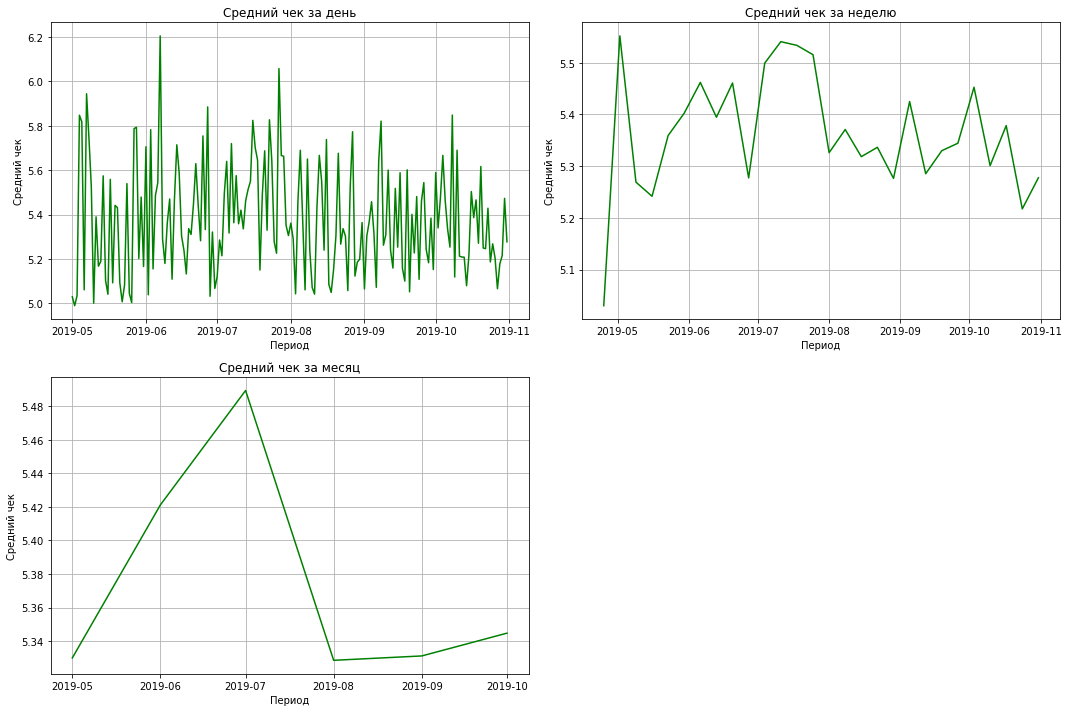

In [53]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)


ax1.plot(receit_day['receit_day'], color = 'green')
ax1.set_ylabel('Средний чек')
ax1.set_xlabel('Период')
ax1.set_title('Средний чек за день')
ax1.grid()

ax2.plot(receit_week['receit_week'], color='green')
ax2.set_ylabel('Средний чек')
ax2.set_xlabel('Период')
ax2.set_title('Средний чек за неделю')
ax2.grid()

ax3.plot(receit_month['receit_month'], color='green')
ax3.set_ylabel('Средний чек')
ax3.set_xlabel('Период')
ax3.set_title('Средний чек за месяц')
ax3.grid()


fig.tight_layout()

Средний чек:
   - за день - 5.375
   - неделю -  5.363
   - месяц - 5.374

Значения практически равны.
Рассматривая изменения во времени, видим пики для среднего чека за день для начала мая, июня, конца августа.
Видим рост среднего чека за месяц для мая, июня и июля.

### Маркетинг:

#### Найдем общую сумму расходов на маркетинг.

In [54]:
costs['costs'].sum()

105497.30000000002

Всего на маркетинг было потрачено 105497 долларов.

Найдем траты на маркетинг по рекламным каналам

In [55]:
cos = costs.groupby(['channel', 'dt']).agg({'costs': 'sum'}).reset_index()
cos.head()

,channel,dt,costs
0,AdNonSense,2019-05-01,40.95
1,AdNonSense,2019-05-02,34.65
2,AdNonSense,2019-05-03,47.25
3,AdNonSense,2019-05-04,51.45
4,AdNonSense,2019-05-05,36.75


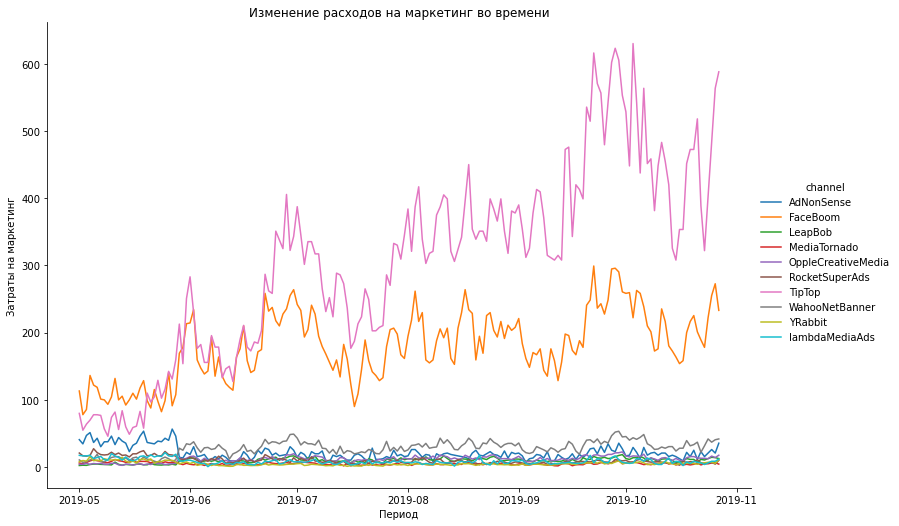

In [56]:
sns.relplot(data=cos,
            kind='line',
            x='dt',
            y='costs',
            hue='channel',
            ci=None,
            height=7, 
            aspect=1.5)
plt.title('Изменение расходов на маркетинг во времени')
plt.xlabel('Период')
plt.ylabel('Затраты на маркетинг')
plt.show()

Всего на маркетинг было потрачено 105497 долларов. Рассматривая полученный график, больше всего расходов на маркетинг связано с рекламными каналами: "TipTop", "FaceBoom". Расходы на маркетинг через остальные рекламные каналы  практически не отличаются.

#### Найдем сколько в среднем стоило привлечение одного пользователя

In [57]:
# САС на одного пользователя для всего проекта

cac = profiles.groupby('user_id').agg({'user_id': 'nunique', 'acquisition_cost': 'mean'}).head(5)
cac['acquisition_cost'].mean()

0.6828826820005787

Найдем САС на одного пользователя для каждого источника трафика

In [58]:
cac_channel = profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending = False)
cac_channel

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Посмотри на динамику САС по рекаламным каналам

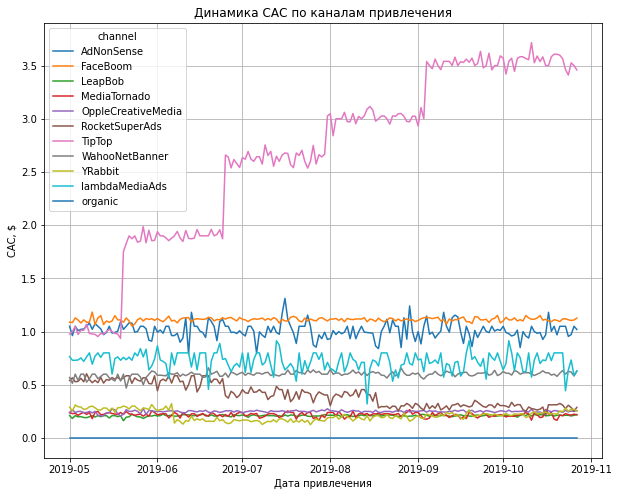

In [59]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 8))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show() 

Средний CAC на одного пользователя для всего проекта составляет - 0.68

Средний CAC на одного пользователя для каждого источника трафика:

  - TipTop - 2.79
  - FaceBoom - 1.11
  - AdNonSense - 1.0
  - lambdaMediaAds  - 0.72
  - WahooNetBanner - 0.60
  - RocketSuperAds - 0.41
  - OppleCreativeMedia - 0.25
  - LeapBob - 0.21
  - MediaTornado - 0.21
  - YRabbit - 0.21
  
  
Рассматривая САС в динамике, видим, что для рекламного канала "TipTop" уровень САС начал расти с середины мая. И уже с сентября достиг отметки в 3.5

## Функции для расчёта и визуализации
<a id="functions"></a>

Функция для для расчёта удержания

In [60]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функцию для расчёта LTV и ROI

In [61]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # что мы здесь делаем???
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Функция для расчёта конверсии

In [62]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для сглаживания фрейма

In [63]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

Функция для визуализации удержания

In [64]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Функция для визуализации конверсии

In [65]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Функция для визуализации LTV и ROI

In [66]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Окупаемость рекламы
<a id="roi"></a>

### Общая окупаемость рекламы

Посчитаем LTV и ROI

In [67]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

ltv_raw, ltv, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days)

Построим графики 

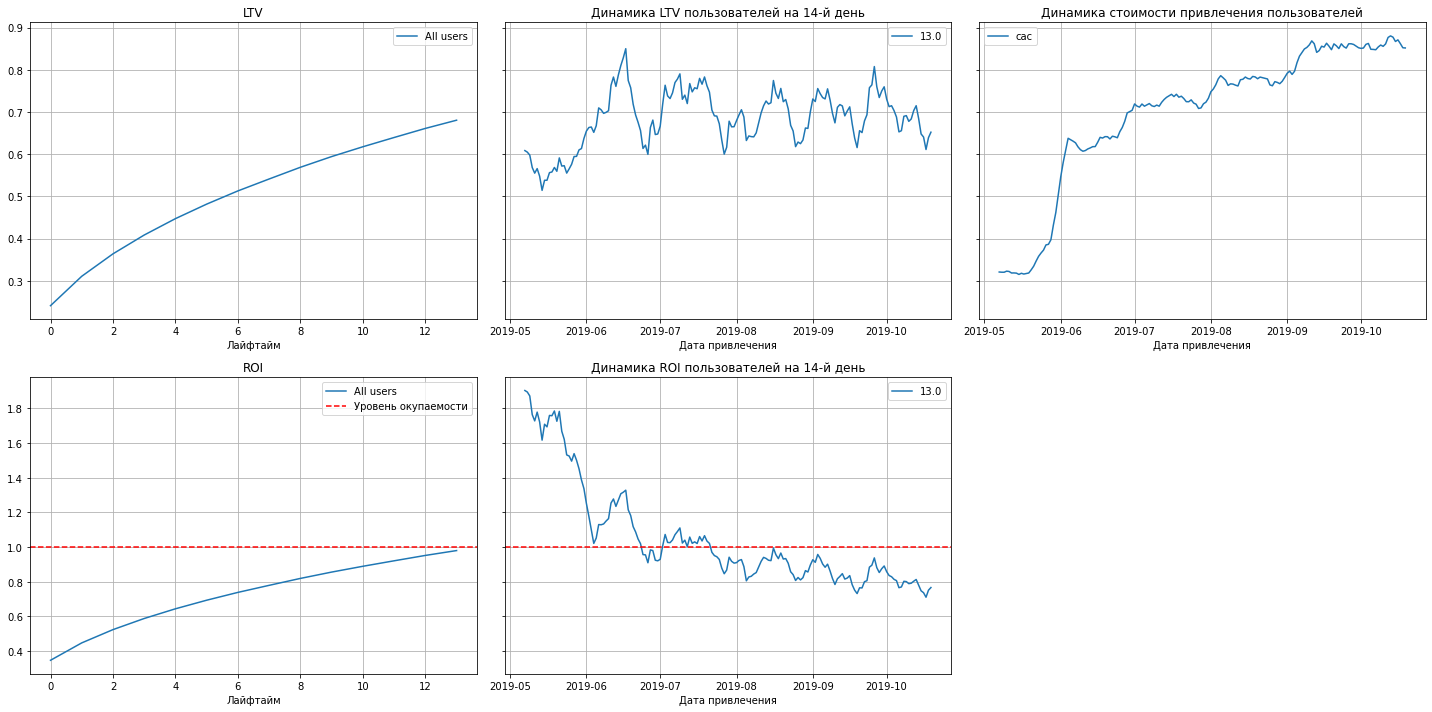

In [68]:
plot_ltv_roi(ltv, ltv_history, roi_grouped, roi_history, horizon_days)

На полученных графиках мы видим следующую картину:
    
  - LTV стабилен
  - CAC растет, денег на привлечение клиентов тратится больше
  - POI не превышает 1.0, затраты на реклату не окупаются. Рассматривая динамику, видим POI в мае и июне выше уровня окупаемости, но начиная с конца июня идет падение POI.

### Конверсия

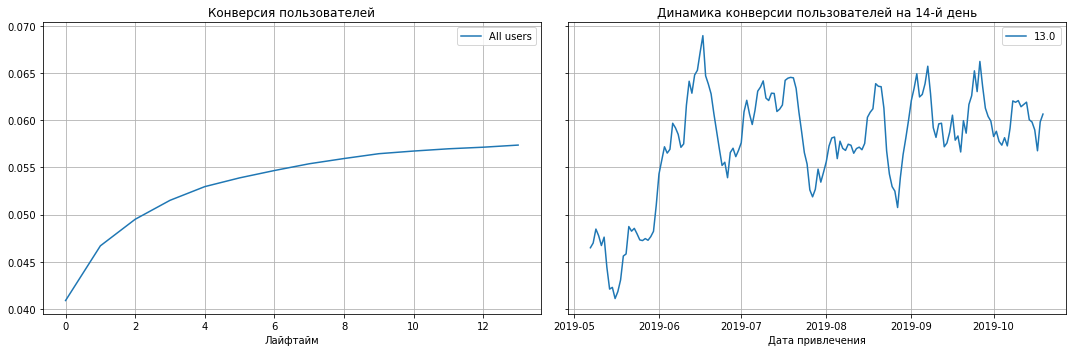

In [69]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion, conversion_history, horizon_days) 

Судя по графикам, конверсия постепенно растет. В мае конверсия была невелика, в июне был максимальный рост, потом падение, а далее небольшой постепенный рост. Рассмотрим конверсию более подробно.

### Удержание

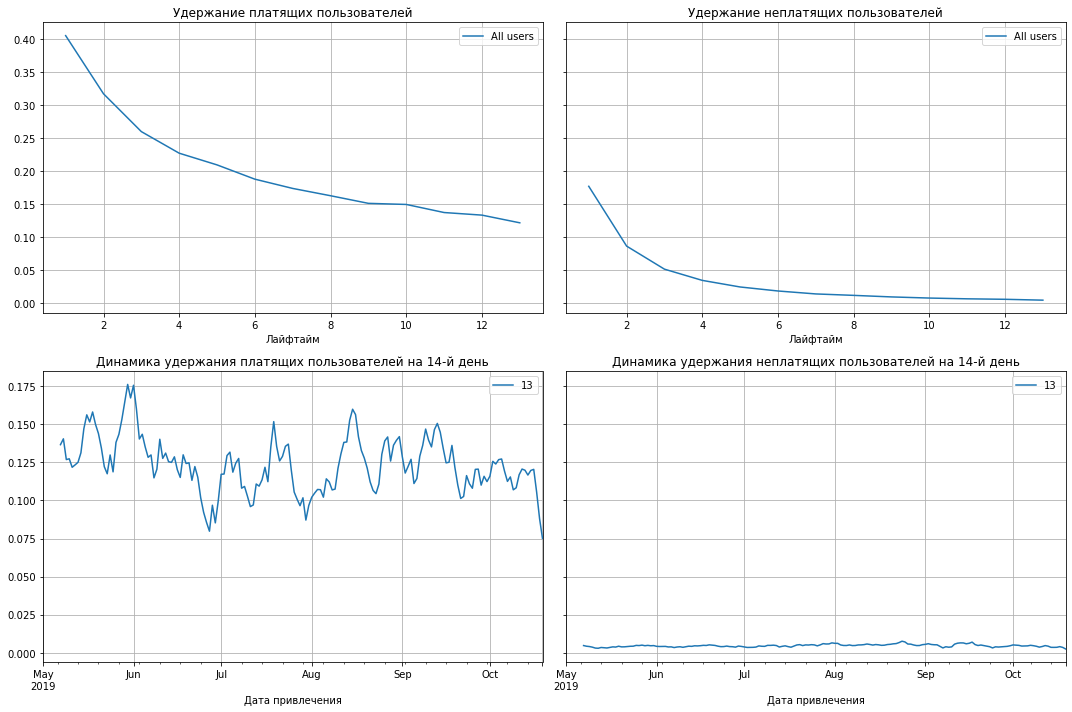

In [70]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention, retention_history, horizon_days) 

Рассматривая удержание можно отметить, что удержание платящих пользователей выше, чем неплатящих. Необходимо рассмотреть этот показатель более подробно.

### Окупаемость рекламы с разбивкой по устройствам

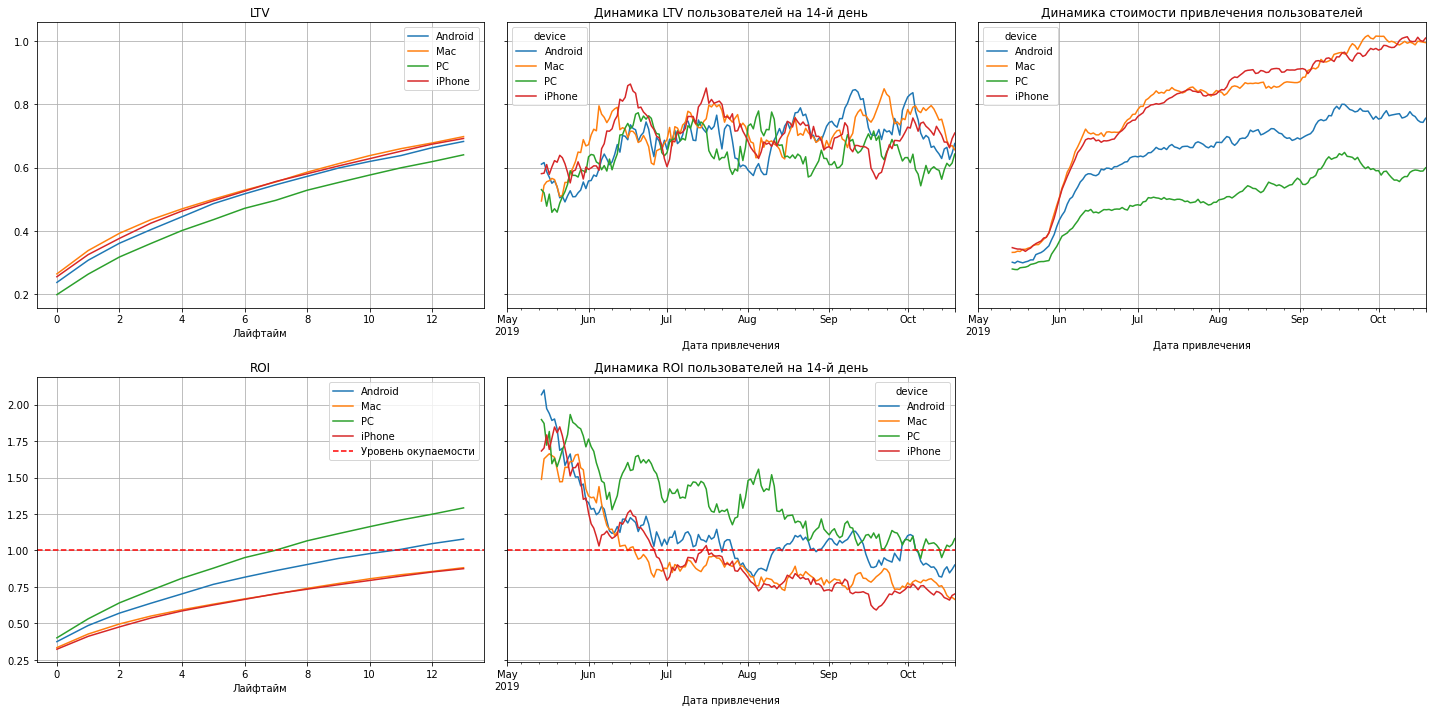

In [71]:
dimensions = ['device']

ltv_raw, ltv, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Чтобы детально разобраться с плохой окупаемостью, посмотрим на графики с разбивкой по устройствам:

   - LTV все также стабилен, качество клиентов хорошее
   - рассматривая стоимость привлечения клиентов, видим, что на привлечение пользователей Iphone и Mac было потрачено гораздо больше денег, чем на пользоватей Android и PC
   - с POI уже другая ситуация: пользователи Android и PC окупаются, а пользователи Iphone и Mac нет.

### Конверсия с разбивкой по устройствам

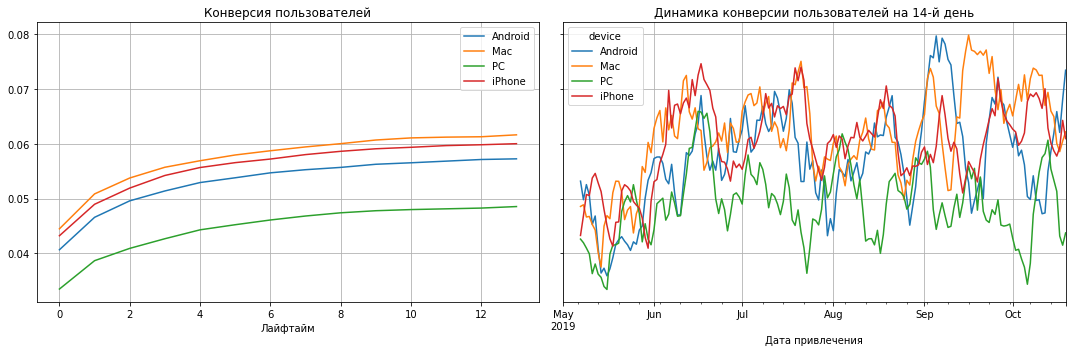

In [72]:
dimensions = ['device']
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion, conversion_history, horizon_days) 

Пользователи Mac и Iphone конвертируют лучше всего и практически одиноково, немного хуже конверитируют пользователи Android, и хуже всех конвертируют пользователи PC.

### Удержание с разбивкой по устройстам

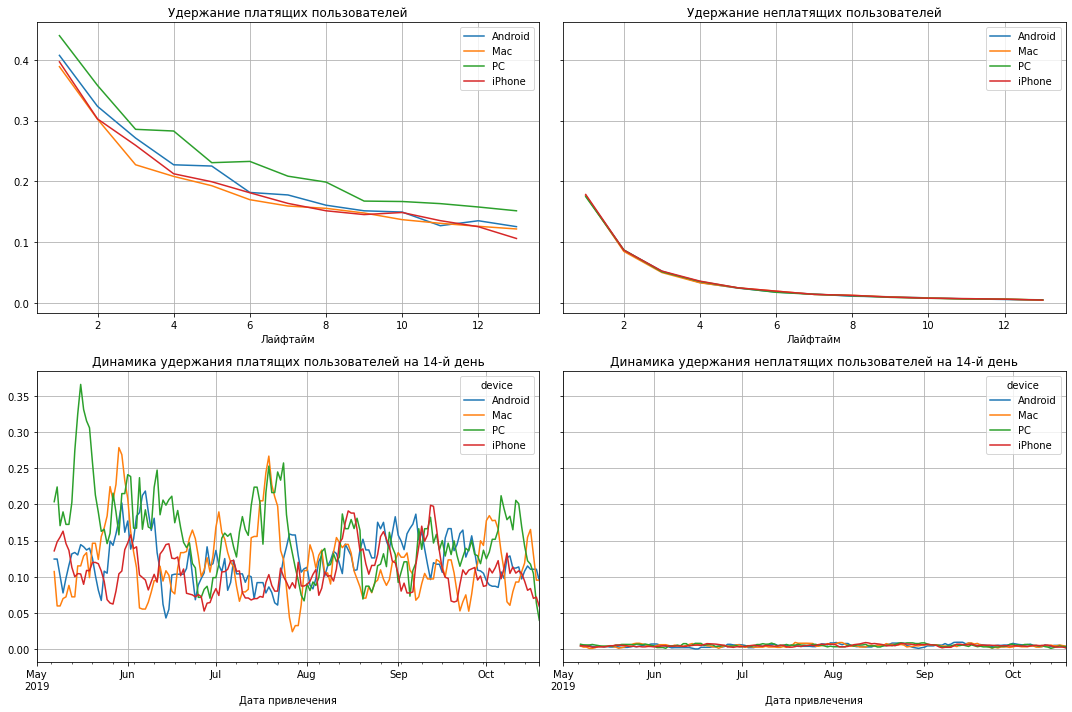

In [73]:
dimensions = ['device']
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention, retention_history, horizon_days) 

Лучше всего удерживаются платящие пользователи PC. Удержание неплатящих пользоватей примерно одинаково.

### Окупаемость рекламы с разбивкой по странам

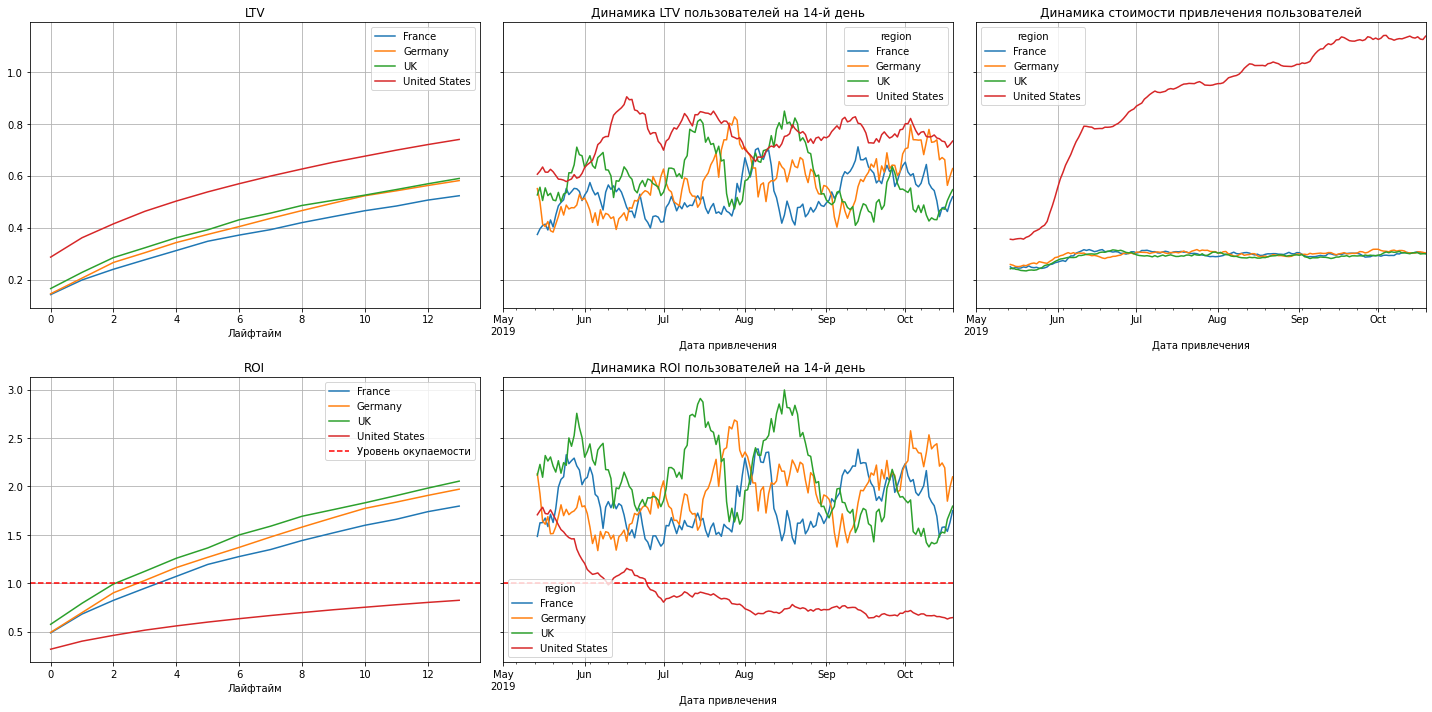

In [74]:
dimensions = ['region']

ltv_raw, ltv, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

С LTV все в порядке, на привлечение пользователей из США потрачено гораздо больше, чем на пользователей из других стран. И пользователи только из США не окупаются, из остальных стран - да.

Рассмотрев более детально окупаемость в США по рекламным каналам, видим, что на привлечение по "TipTop", "FaceBoom" было потрачено гораздо больше (размер когорт по этим каналам велик) и привлечение именно по этим каналам совсем не окупилось. В остальных регионах тоже присутствуют убыточные каналы, но они представлены в единственном числе и расходы на привлечение по ним меньше.

### Конверсия с разбивкой по регионам

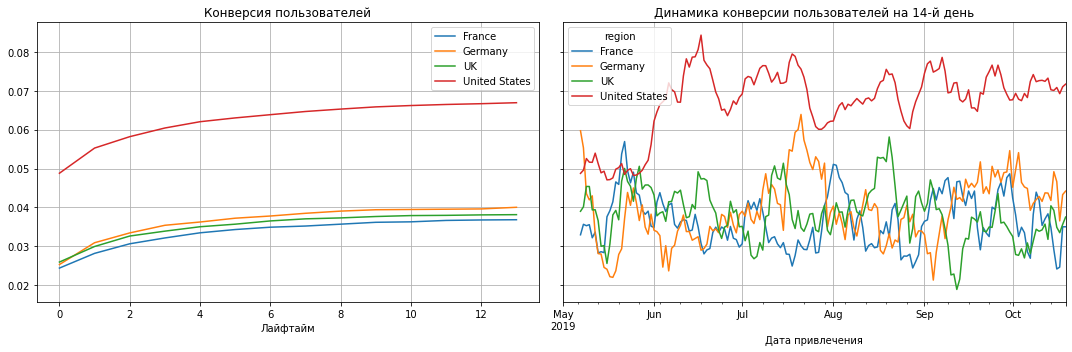

In [75]:
dimensions = ['region']
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion, conversion_history, horizon_days) 

Пользователи из США конвертируют гораздо лучше пользователей из других стран.

### Удержание с разбивкой по регионам

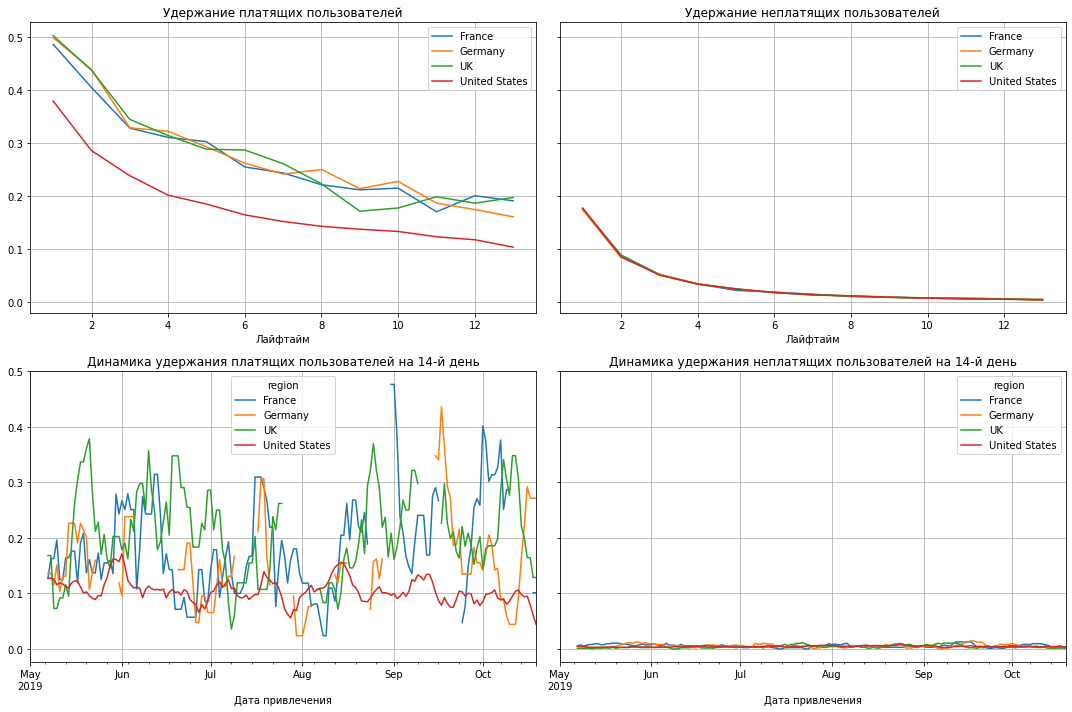

In [76]:
dimensions = ['region']
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention, retention_history, horizon_days) 

Удержание платящих пользователей из США происходит гораздо хуже, чем пользователей из других стран. Удежание неплатящих пользователей опять же не отличается.

### Окупаемость рекламы с разбивкой по рекламным каналам

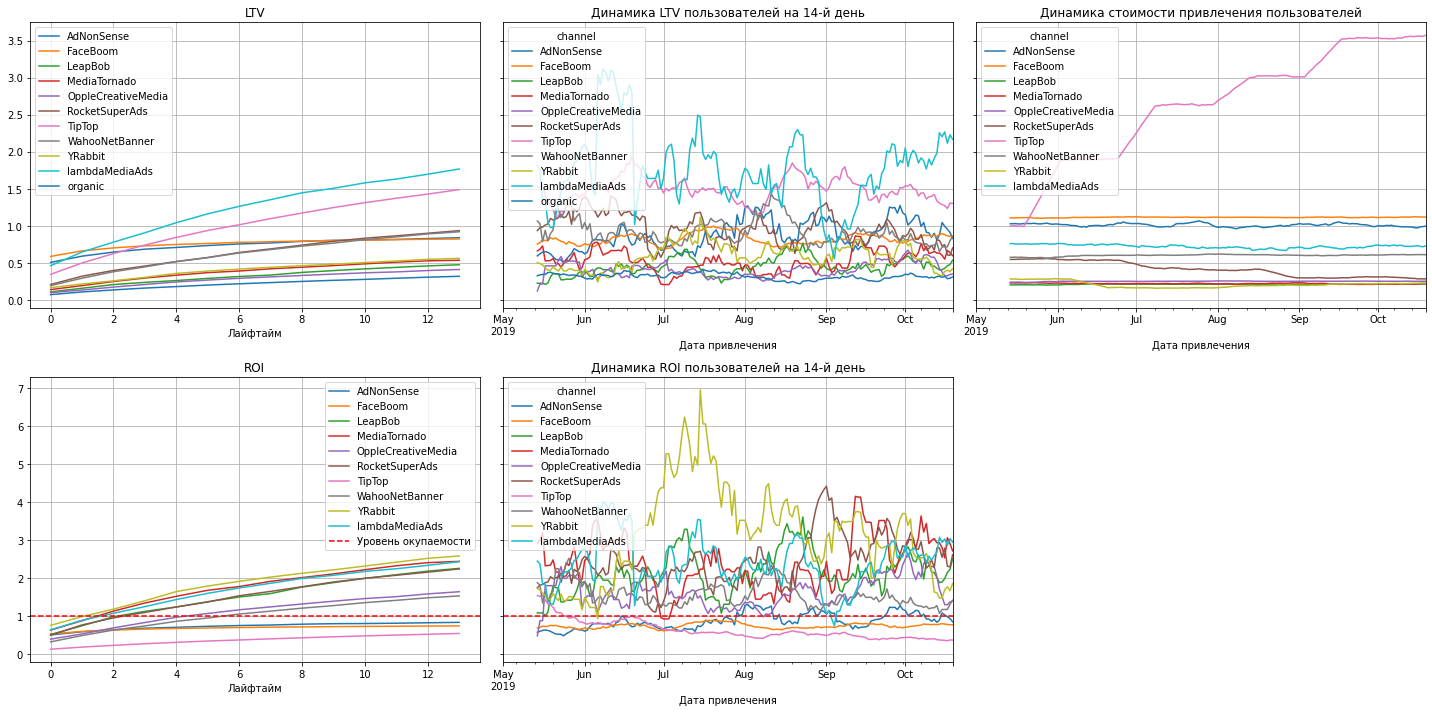

In [77]:
dimensions = ['channel']

ltv_raw, ltv, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Рассматривая показатели с разбивкой по рекламным каналам, выводы следующие:

   - стоимость привлечения по рекламному каналу TipTop гораздо выше остальных каналов, и стоимость привлечения не была одинаковой, она постоянно повышалась
   - ситуация с POI: не окупаются только 3 канала - AdNonSense, FaceBoom, TipTop

### Конверсия с разбивкой по рекламным каналам

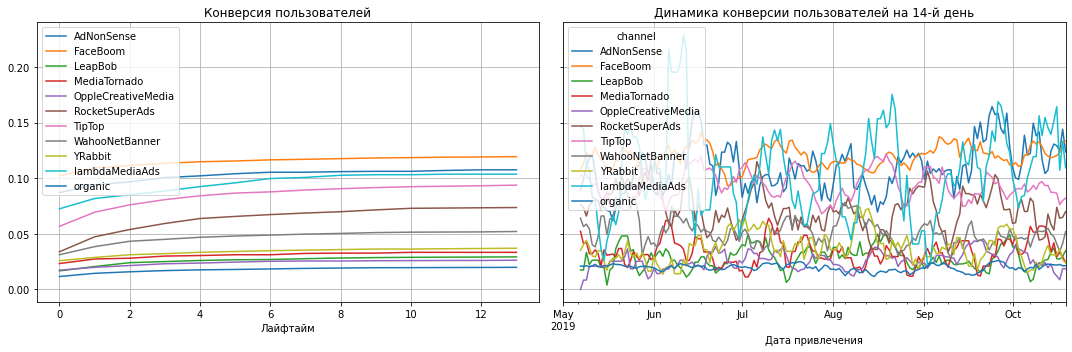

In [78]:
dimensions = ['channel']
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion, conversion_history, horizon_days) 

Пользователи, пришедшие по рекламному каналу FaceBoom немного лучше, чем пользователи пришедшие по другим рекламны каналам. Но эта разница совсем не существенна.

### Удержание с разбивкой по рекламным каналам

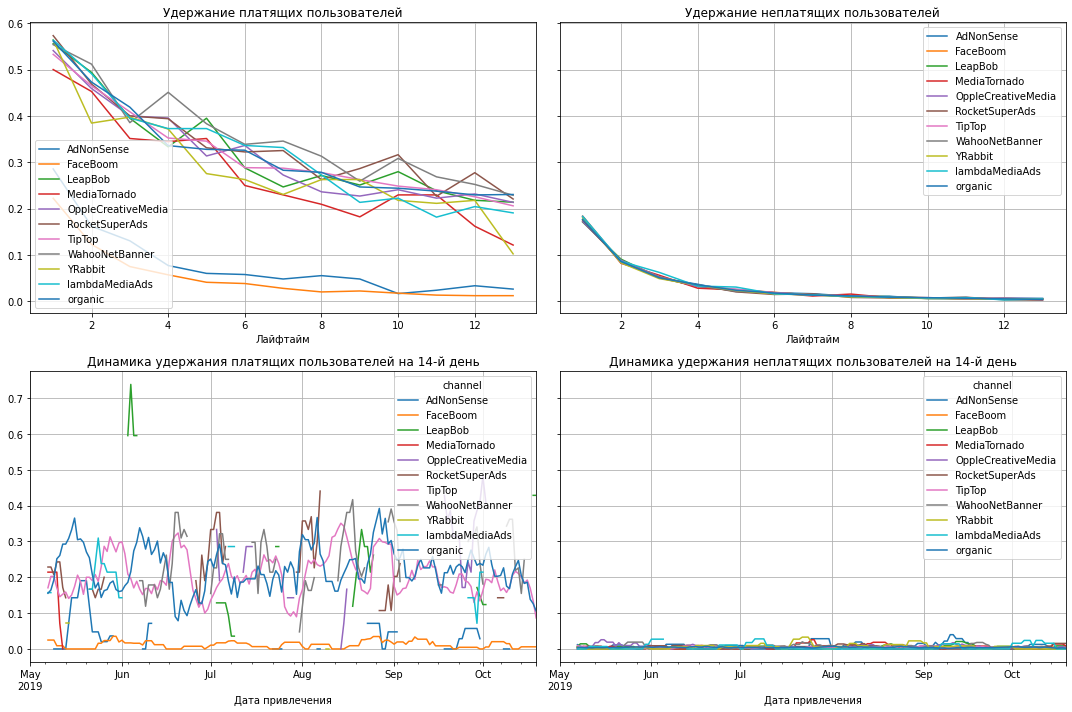

In [79]:
dimensions = ['channel']
retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention, retention_history, horizon_days) 

Удержание платящих пользователей из рекламных каналов AdNonSense, FaceBoom ниже всего. Выделить лидера по удержанию трудно, все остальные пользователи из рекланых каналов удерживаются примерно одинаково. 

## Вывод
<a id="end"></a>

Имея данные (лог сервера с данными об их посещениях, выгрузка их покупок за этот период, рекламные расходы) развлекательного приложения Procrastinate Pro+ была проведена работа для нахождения причин, по которым компания терпит убытки.

**1. Вначале были найдены даты привлечения пользователей:**

 - 2019-05-01 - минимальная дата привлечения пользователей
 - 2019-10-01 - максимальная дата привлечения пользователей

а также :
  
   - США - страна, которая дает больше всего платящих пользователей
   - Mac - устройство, с которого чаще всего заходят платящие пользователи
   - FaceBoom - канал, который приносит больше всего платящих пользователей

**2. Проанализирована общая окупаемость рекламы:**
   - затраты на реклату не окупаются
   - начиная с июня росли траты на рекламу

**3. Чтобы разобраться в причинах плохой окупаемости, были рассмотрены доступные характеристики пользователей — устройства, страна, рекламные каналы:**
  
    POI:
     
   - пользователи Android и PC окупаются, пользователи Iphone и Mac - нет
   - пользователи из Франции, Германии, Великобритании окупаются, пользователи из США - нет
   - не окупаются только 3 рекламных канала - AdNonSense, FaceBoom, TipTop
   
  CAC:
     
   - на привлечение пользователей Iphone и Mac было потрачено гораздо больше денег, чем на пользоватей Android и PC 
   - траты на привлечение пользователей из США выше, чем траты на пользователей из других стран
   - стоимость привлечения пользователей по рекламному каналу TipTop гораздо выше остальных каналов
   
  Конверсия:
     
   - Пользователи Mac и Iphone конвертируют лучше всего и практически одиноково, немного хуже конверитируют пользователи Android, и хуже всех конвертируют пользователи PC.
   - пользователи из США конвертируют гораздо лучше пользователей из других стран
   - пользователи, пришедшие по рекламному каналу FaceBoom конвертируют немного лучше, чем пользователи пришедшие по другим рекламны каналам. Но эта разница совсем не существенна.
   
 Удержание:
     
   - лучше всего удерживаются платящие пользователи PC. Удержание неплатящих пользоватей примерно одинаково
   - удержание платящих пользователей из США происходит гораздо хуже, чем пользователей из других стран. Удежание неплатящих пользователей опять же не отличается.
   - удержание платящих пользователей из рекламных каналов AdNonSense, FaceBoom ниже всего. Выделить лидера по удержанию трудно, все остальные пользователи из рекланых каналов удерживаются примерно одинаково.
   
**4. Подводя итог о проделанной работе, можно сказать следующее:**

   - необходимо пересмотреть траты на привлечение пользователей из США, пользователей Iphone и Mac и пользователей, прищедших по рекламным каналам AdNonSense, FaceBoom, TipTop. Конверсия у пользоваталелей этих категорий хорошая, но ее уровень не достаточен для того, чтобы траты на рекламу окупились. Из этого следует необходимость повешения конверсии.
   - рассматривая удержание пользователей этих категорий, опять мы видим отрицательные результаты. Пользователи плохо удерживаются. Необходимо найти причину плохого удержания, в первую очередь проверить на технические ошибки.